# Demo Notebook for Creating a Pitch by Pitch Report with Reboot Motion Metrics

Run the cells in order, making sure to enter AWS credentials in the cell when prompted


In [ ]:
#@title Install Python Package

!pip install -q git+https://github.com/RebootMotion/colab-notebook-utils.git@v1.0.0#egg=colab_notebook_utils

In [1]:
import boto3
import colab_notebook_utils as utils
import matplotlib.pyplot as plt
import os
import pandas as pd

from colab_notebook_utils import S3Metadata, MocapType, MovementType, Handedness, FileType, PlayerMetadata
from IPython.display import display

In [2]:
#@title Org and AWS Credentials

from dotenv import load_dotenv

load_dotenv()

if 'AWS_ACCESS_KEY_ID' not in os.environ:
    from getpass import getpass

    os.environ['ORG_ID'] = getpass('Enter reboot-motion org_id here:')
    os.environ['AWS_ACCESS_KEY_ID'] = getpass('Enter AWS_ACCESS_KEY_ID here:')
    os.environ['AWS_SECRET_ACCESS_KEY'] = getpass('Enter SECRET_ACCESS_KEY here:')
    os.environ['AWS_DEFAULT_REGION'] = getpass('Enter AWS_DEFAULT_REGION here:')

boto3_session = boto3.session.Session(
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
    region_name=os.environ['AWS_DEFAULT_REGION']
    )

print('Current Boto3 Session:')
print(boto3_session)

Current Boto3 Session:
Session(region_name='us-west-1')


In [3]:
#@title Set S3 File Info

s3_metadata = S3Metadata(
    org_id=os.environ['ORG_ID'],
    mocap_types=[MocapType.HAWKEYE_HFR],
    movement_type=MovementType.BASEBALL_PITCHING,
    handedness=Handedness.LEFT,
    file_type=FileType.METRICS_BASEBALL_PITCHING_V2
)

s3_df = utils.download_s3_summary_df(s3_metadata)

Available data...

session_date
['2022-10-02T00:00:00.000000000' '2023-02-25T00:00:00.000000000'
 '2023-02-26T00:00:00.000000000' '2023-02-27T00:00:00.000000000'
 '2023-02-28T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-12T00:00:00.000000000' '2023-03-25T00:00:00.000000000'
 '2023-03-28T00:00:00.000000000' '2023-03-30T00:00:00.000000000'
 '2023-03-31T00:00:00.000000000' '2023-04-01T00:00:00.000000000'
 '2023-04-02T00:00:00.000000000' '2023-04-03T00:00:00.000000000'
 '2023-04-04T00:00:00.000000000' '2023-04-05T00:00:00.000000000'
 '2023-04-06T00:00:00.000000000' '2023-04-07T00:00:00.000000000'
 '2023-04-08T00:00:00.000000000' '2023-04-09T00:00:00.000000000'
 '2023-04-10T00:00:00.000000000' '2023-04-11T00:00:00.000000000'
 '2023-04-12T00:00:00.000000000' '2023-04-13T00:00:00.000000000'
 '2023-04-14T00:00:00.000000000' '2023-04-15T00:00:00.000000000'
 '2023-04-16T00:00:00.000000000' '2023-04-17T00:00:00.000000000'
 '2023-04-18T00:00:00.000000000' '2023-04-19T00:00:00.0000

In [4]:
primary_segment_widget = utils.create_interactive_widget(s3_df)

display(primary_segment_widget)

interactive(children=(SelectMultiple(description='Players', options=('408234', '425844', '443558', '444482', '…

In [5]:
print('Options selected (re-run the above cell to refresh):')
print(primary_segment_widget.result)

Options selected (re-run the above cell to refresh):
{'org_player_ids': ['605488'], 'session_nums': None, 'session_dates': ['2023-04-13'], 'session_date_start': None, 'session_date_end': None, 'year': 2023}


In [6]:
#@title Set Primary Analysis Segment Info

primary_segment_label = '2023-04-13 (Injured)'

primary_analysis_segment = PlayerMetadata(
    org_player_ids=primary_segment_widget.result["org_player_ids"],
    session_dates=primary_segment_widget.result["session_dates"],
    session_nums=primary_segment_widget.result["session_nums"],
    session_date_start=primary_segment_widget.result["session_date_start"],
    session_date_end=primary_segment_widget.result["session_date_end"],
    year=primary_segment_widget.result["year"],
    org_movement_id=None, # set the mlb play GUID for the skeleton animation; None defaults to the first play
    s3_metadata=s3_metadata,
)

primary_segment_summary_df = utils.filter_s3_summary_df(primary_analysis_segment, s3_df)

Available data...

session_date
['2023-04-13T00:00:00.000000000']

year
[2023]

org_player_id
<StringArray>
['605488']
Length: 1, dtype: string

movement_type
['baseball-pitching']

session_type
['session']

session_num
<StringArray>
['718594']
Length: 1, dtype: string

mocap_type
['hawkeyehfr']

s3_path_delivery
['s3://reboot-motion-org-mlbbiomech/data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/']



In [7]:
#@title Add Movement Num and S3 Key to Primary DataFrame to Enable Sorting

prim_available_s3_keys = utils.list_available_s3_keys(os.environ['ORG_ID'], primary_segment_summary_df)

primary_segment_data_df = utils.load_games_to_df_from_s3_paths(primary_segment_summary_df['s3_path_delivery'].tolist())

primary_segment_data_df = utils.merge_data_df_with_s3_keys(primary_segment_data_df, prim_available_s3_keys).sort_values(by=['session_date', 'movement_num'])

s3 base path: s3://reboot-motion-org-mlbbiomech/data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/
available s3 files:
['data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/000_afe21ab0-f7b0-46b5-96d4-918b638d35a0_metrics.csv', 'data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/001_5a32f995-d2cc-4d6e-86e7-c81dcb6457f2_metrics.csv', 'data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/002_c9414c6a-6949-4229-884f-577fac68dd93_metrics.csv', 'data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/003_1748d5b2-aef5-4b78-a622-e082ba3332b4_metrics.csv', 'data_delivery/hawkeyehfr/20230413/718594/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/004_b0219b50-8ca9-4575-b4be-164639ffbdea_metrics.csv', 'data_delivery/hawkeyehfr/20230413/718594/baseball-pitch

In [9]:
comparison_segment_widget = utils.create_interactive_widget(s3_df)

display(comparison_segment_widget)

interactive(children=(SelectMultiple(description='Players', options=('408234', '425844', '443558', '444482', '…

In [10]:
print('Options selected (re-run the above cell to refresh):')
print(comparison_segment_widget.result)

Options selected (re-run the above cell to refresh):
{'org_player_ids': ['605488'], 'session_nums': None, 'session_dates': None, 'session_date_start': None, 'session_date_end': datetime.date(2023, 4, 12), 'year': 2023}


In [11]:
#@title Optional - Uncomment below and set Comparison Analysis Segment Inputs

comparison_segment_label = 'Early 2023'

comparison_s3_metadata = s3_metadata

comparison_analysis_segment = PlayerMetadata(
    org_player_ids=comparison_segment_widget.result["org_player_ids"],
    session_dates=comparison_segment_widget.result["session_dates"],
    session_nums=comparison_segment_widget.result["session_nums"],
    session_date_start=comparison_segment_widget.result["session_date_start"],
    session_date_end=comparison_segment_widget.result["session_date_end"],
    year=comparison_segment_widget.result["year"],
    org_movement_id=None, # set the mlb play GUID for the skeleton animation; None defaults to the first play
    s3_metadata=comparison_s3_metadata,
)

comparison_segment_summary_df = utils.filter_s3_summary_df(comparison_analysis_segment, s3_df)

comp_available_s3_keys = utils.list_available_s3_keys(os.environ['ORG_ID'], comparison_segment_summary_df)

comparison_segment_data_df = utils.load_games_to_df_from_s3_paths(comparison_segment_summary_df['s3_path_delivery'].tolist())

comparison_segment_data_df = utils.merge_data_df_with_s3_keys(comparison_segment_data_df , comp_available_s3_keys).sort_values(by=['session_date', 'movement_num'])

Available data...

session_date
['2023-04-02T00:00:00.000000000' '2023-04-08T00:00:00.000000000']

year
[2023]

org_player_id
<StringArray>
['605488']
Length: 1, dtype: string

movement_type
['baseball-pitching']

session_type
['session']

session_num
<StringArray>
['718742', '718665']
Length: 2, dtype: string

mocap_type
['hawkeyehfr']

s3_path_delivery
['s3://reboot-motion-org-mlbbiomech/data_delivery/hawkeyehfr/20230402/718742/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/'
 's3://reboot-motion-org-mlbbiomech/data_delivery/hawkeyehfr/20230408/718665/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/']

s3 base path: s3://reboot-motion-org-mlbbiomech/data_delivery/hawkeyehfr/20230402/718742/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/
available s3 files:
['data_delivery/hawkeyehfr/20230402/718742/baseball-pitching/605488/metrics-baseball-pitching-v2-0-0/000_76aec426-c04a-4e6b-9a99-04bef4d7d25d_metrics.csv', 'data_delivery/hawkeyehfr/20230402/718742/b

In [12]:
comparison_segment_data_df['segment_type'] = 'comparison'

primary_segment_data_df['segment_type'] = 'primary'

analysis_df = pd.concat([comparison_segment_data_df, primary_segment_data_df]).sort_values(by=['session_date', 'movement_num']).reset_index(drop=True)

In [13]:
print('Available metrics:')
print()
print(list(analysis_df))

Available metrics:

['time_length', 'move_direction_x', 'move_direction_y', 'move_direction_z', 'feet_separation_m', 'rear_leg_proj_max', 'rear_leg_proj_norm_time', 'rear_leg_proj_end', 'lead_leg_proj_max', 'lead_leg_proj_norm_time', 'lead_leg_proj_end', 'lower_half_proj_max', 'lower_half_proj_norm_time', 'lower_half_proj_end', 'lead_arm_proj_max', 'lead_arm_proj_norm_time', 'lead_arm_proj_end', 'torso_proj_max', 'torso_proj_norm_time', 'torso_proj_end', 'pitch_up_arm_proj_max', 'pitch_up_arm_proj_norm_time', 'pitch_up_arm_proj_end', 'pitch_forearm_proj_max', 'pitch_forearm_proj_norm_time', 'pitch_forearm_proj_end', 'pitch_hand_proj_max', 'pitch_hand_proj_norm_time', 'pitch_hand_proj_end', 'total_proj_max', 'total_proj_norm_time', 'total_proj_end', 'rear_leg_side_max', 'rear_leg_side_max_percent', 'rear_leg_side_max_norm_time', 'rear_leg_side_min', 'rear_leg_side_min_percent', 'rear_leg_side_min_norm_time', 'rear_leg_vert_ang', 'lead_leg_side_max', 'lead_leg_side_max_percent', 'lead_le

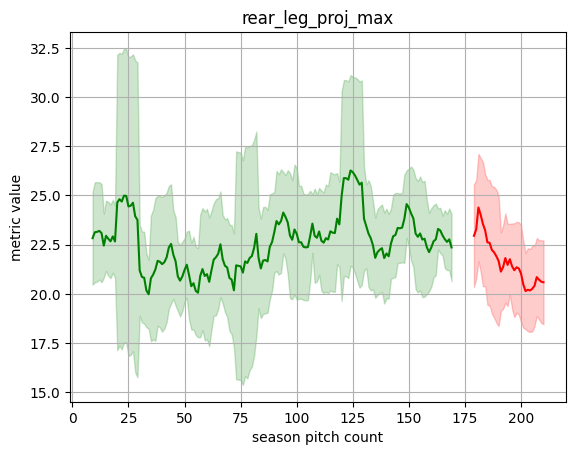

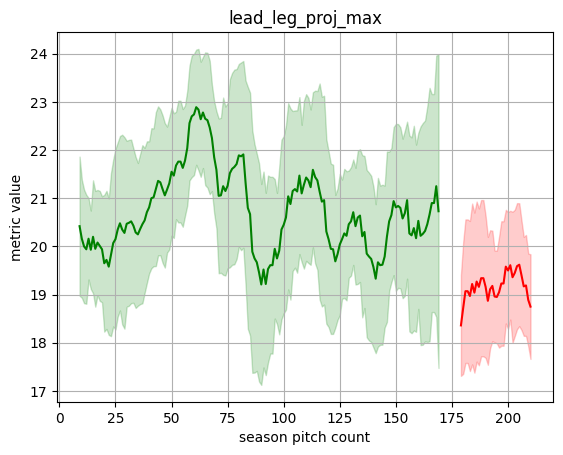

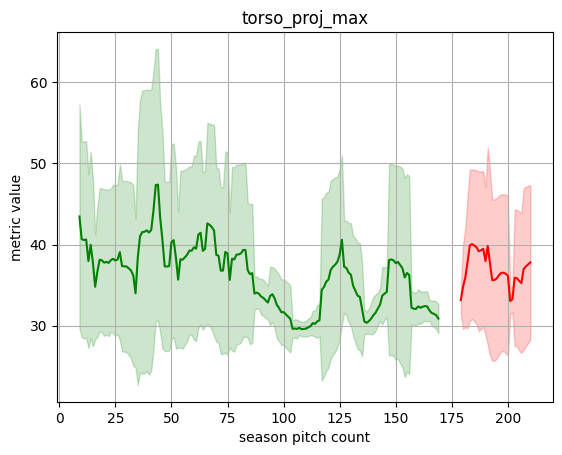

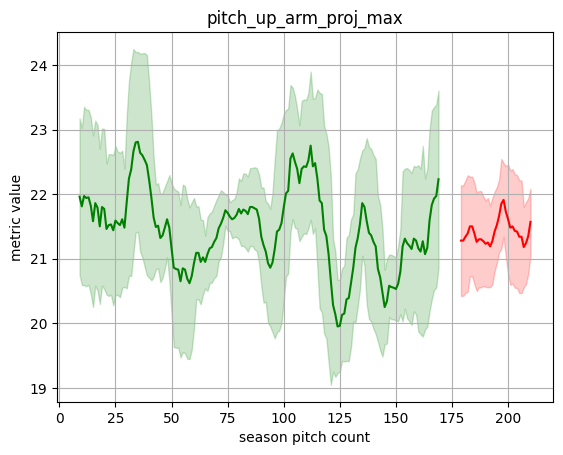

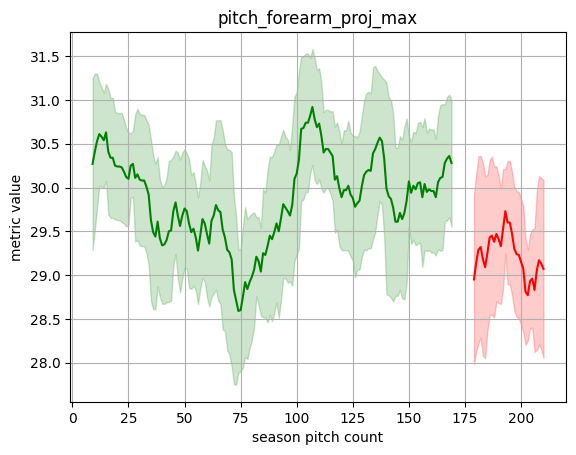

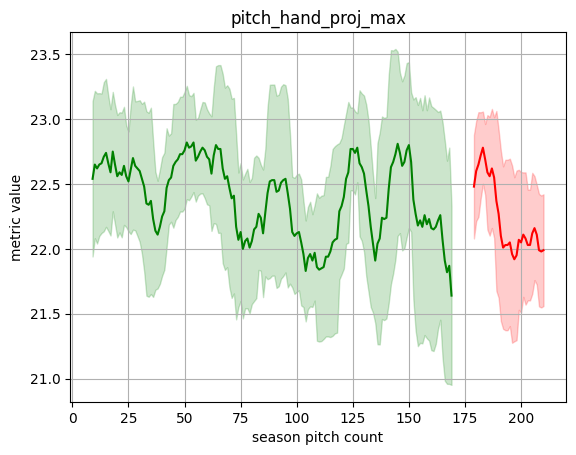

In [14]:
body_segments = ['rear_leg', 'lead_leg', 'torso', 'pitch_up_arm', 'pitch_forearm', 'pitch_hand']
metric_categories = ['proj_max']
metrics = [f"{body_seg}_{metric_cat}" for body_seg in body_segments for metric_cat in metric_categories]

# body_joints = ['rear_hip_ir', 'lead_knee_flex', 'lumbar_ext', 'spine_rot', 'pitch_shoulder_horz', 'pitch_shoulder_rot', 'pitch_elbow_flex']
# metric_categories = ['range_full_min', 'range_full_max', 'range_min', 'range_max', 'range_norm]
# metrics = [f"{body_joint}_{metric_cat}" for body_joint in body_joints for metric_cat in metric_categories]

# metrics = ['lower_half_to_torso_proj', 'torso_to_up_arm_proj', 'up_arm_to_pitch_hand_proj']

comparison_color = 'green'
primary_color = 'red'

rolling_window = 10

figs = []

comparison = analysis_df.loc[analysis_df['segment_type'] == 'comparison']
x_comp = comparison.index.tolist()

primary = analysis_df.loc[analysis_df['segment_type'] == 'primary']
x_prim = primary.index.tolist()

for metric in metrics:

    y_comp = comparison[metric].rolling(window=rolling_window).mean()
    y_comp_std = comparison[metric].rolling(window=rolling_window).std()

    y_comp_lo = y_comp - y_comp_std
    y_comp_hi = y_comp + y_comp_std

    y_prim = primary[metric].rolling(window=rolling_window).mean()
    y_prim_std = primary[metric].rolling(window=rolling_window).std()

    y_prim_lo = y_prim - y_prim_std
    y_prim_hi = y_prim + y_prim_std

    fig = plt.figure()

    plt.fill_between(x_comp, y_comp_lo, y_comp_hi, color=comparison_color, alpha=0.2)
    plt.plot(x_comp, y_comp, comparison_color)

    plt.fill_between(x_prim, y_prim_lo, y_prim_hi, color=primary_color, alpha=0.2)
    plt.plot(x_prim, y_prim, primary_color)

    plt.ylabel('metric value')
    plt.xlabel('season pitch count')
    plt.title(metric)

    plt.grid()

    figs.append(fig)

    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_file_name = 'analysis_pitch_by_pitch.pdf'

pdf_analysis = PdfPages(pdf_file_name)

for fig in figs:

    pdf_analysis.savefig(fig)

pdf_analysis.close()

print('Saved plots to', pdf_file_name)